In [1]:
from cluster import *
from load_data import *
from matplotlib import pyplot as plt
import sklearn, torch, random, numpy as np, pickle
from torch.nn import ModuleList, functional as F
from sklearn.model_selection import train_test_split
from torch import nn, optim
from os.path import isfile
from sklearn.linear_model import LinearRegression

seed_num = 1
torch.manual_seed(seed_num)
np.random.seed(seed_num) #also sets sklearn seed
random.seed(seed_num)

In [2]:
file = '../Data/stations.dat'
if not isfile(file):
    save_stations(file)
station_id, coord, groups = cluster(file)
coord = np.array(coord)

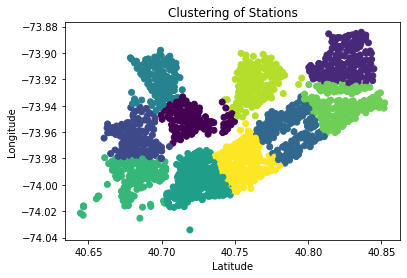

In [3]:
plt.scatter(coord[:, 0], coord[:, 1], c=groups)
plt.title('Clustering of Stations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.savefig('../Graphs/Cluster.png')
plt.show()

In [4]:
class NN(nn.Module):
    def __init__(self, in_width, out_width, layer_widths):
        super(NN, self).__init__()
        self.layers = ModuleList()
        self.decoding = ModuleList()
        self.layers.append(nn.Linear(in_width, layer_widths[0]))
        for i in range(1, len(layer_widths)):
            self.layers.append(nn.Linear(layer_widths[i - 1], layer_widths[i]))
        self.layers.append(nn.Linear(layer_widths[-1], out_width))
        for layer in self.layers:
            nn.init.kaiming_normal_(layer.weight)
        self.optimizer = optim.Adam(self.parameters())
        self.mse = nn.MSELoss()

    def loss_f(self, prediction, target):
        loss = 0
        for i in range(len(prediction)):
            loss += self.mse(prediction[i], target[i])
        return loss
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = nn.ReLU()(x)
        x = self.layers[-1](x)
        return x
        
    def learn(self, train, validation,*, intervals=100, epochs=100000, file=None):
        epochs = tqdm_notebook(range(epochs))
        min_val_loss = float('inf')
        train_losses, val_losses = [], []
        for epoch in epochs:
            self.zero_grad()

            predictions = self(train[0])
            loss = self.loss_f(predictions, train[1])
            if epoch % intervals == 0:
                train_losses.append(float(loss))
                val_predictions = self(validation[0])
                
                val_loss = self.loss_f(val_predictions, validation[1])
                val_losses.append(float(val_loss))
                min_val_loss = min(min_val_loss, val_loss)
                if val_loss > min_val_loss * 1.05 and epoch > 10000:
                    break
            loss.backward()
            self.optimizer.step()
        x = list(range(0, epoch+1, intervals))
        plt.plot(x, train_losses, label='Train Loss')
        plt.plot(x, val_losses, label='Validation Loss')
        if file is not None:
            plt.savefig(file)
        plt.show()
        print(f'Ended at epoch {epoch} with loss of {val_loss}\n{val_loss/min_val_loss}')


In [5]:
file = '../Data/data.dat'
if isfile(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
else:
    data = load({station_id[i]: groups[i] for i in range(len(station_id))}, file)

  0%|          | 0/100000 [00:00<?, ?it/s]

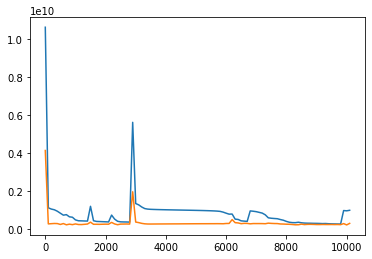

Ended at epoch 10100 with loss of 283163584.0
1.3955602645874023


  0%|          | 0/100000 [00:00<?, ?it/s]

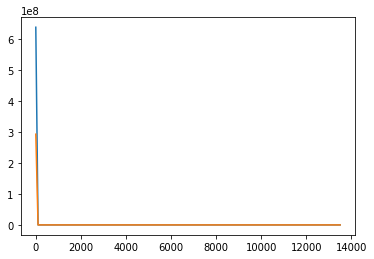

Ended at epoch 13500 with loss of 19.59048080444336
1.1277798414230347


In [6]:
x, y, y2 = data
x, y, y2 = torch.tensor(x).float(), torch.tensor(y).float(), torch.tensor(y2).float()
x_train, x_test, y_train, y_test, y2_train, y2_test = train_test_split(x, y, y2)
x_train, x_val, y_train, y_val, y2_train, y2_val = train_test_split(x_train, y_train, y2_train)

repair = NN(len(x_train[0]), len(y_train[0]), [10]*30)
file = '../Data/repair.pt'
if isfile(file):
    repair.load_state_dict(torch.load(file))
    repair.eval()
else:
    repair.learn((x_train, y_train), (x_val, y_val), file='../Graphs/Repair')
    torch.save(repair.state_dict(), file)  

demand = NN(len(x_train[0]), len(y2_train[0]), [10]*30)
file = '../Data/demand.pt'
if isfile(file):
    demand.load_state_dict(torch.load(file))
    demand.eval()
else:
    demand.learn((x_train, y2_train), (x_val, y2_val), file='../Graphs/Demand')
    torch.save(demand.state_dict(), file)  

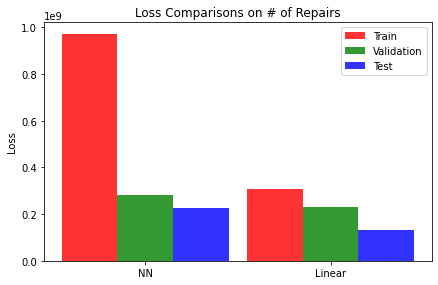

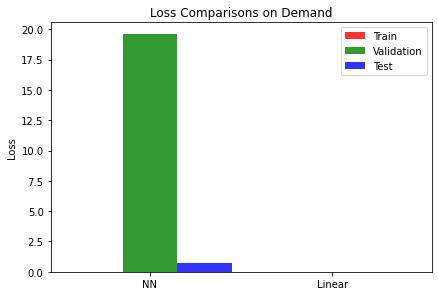

In [7]:
repair_linear = LinearRegression().fit(x_train, y_train)

class MultiOutputLinear:
    def __init__(self):
        self.models = []
    def fit(self, x, y):
        y = y.numpy()
        for i in range(len(y[0])):
            self.models.append(LinearRegression().fit(x, y[:, i]))
    def predict(self, x):
        out = []
        for i in self.models:
            out.append(i.predict(x))
        out = np.array(out)
        out = out.transpose()
        return out

demand_linear = MultiOutputLinear()
demand_linear.fit(x_train, y2_train)
losses = []
r_linear = LinearRegression().fit(x_train, y_train)
for x, y1, y2 in [(x_train, y_train, y2_train), (x_val, y_val, y2_val), (x_test, y_test, y2_test)]:
    neural = repair(x)
    linear = torch.tensor(r_linear.predict(x))
    losses.append((int(repair.loss_f(neural, y1)), int(repair.loss_f(linear, y1))))
index = np.arange(2)
for i, c, l in [(0, 'r', 'Train'), (1, 'g', 'Validation'), (2, 'b', 'Test')]:
    plt.bar(index+i*0.3, losses[i], 0.3, alpha=0.8, color=c, label=l)
plt.xticks(index + 0.3, ('NN', 'Linear'))
plt.legend()
plt.tight_layout()
plt.title('Loss Comparisons on # of Repairs')
plt.ylabel('Loss')
plt.savefig('../Graphs/repair_loss.png')
plt.show()

losses = []
for x, y1, y2 in [(x_train, y_train, y2_train), (x_val, y_val, y2_val), (x_test, y_test, y2_test)]:
    neural = demand(x)
    linear = torch.tensor(demand_linear.predict(x))
    losses.append((float(demand.loss_f(neural, y2)), float(demand.loss_f(linear, y2))))
index = np.arange(2)
for i, c, l in [(0, 'r', 'Train'), (1, 'g', 'Validation'), (2, 'b', 'Test')]:
    plt.bar(index+i*0.3, losses[i], 0.3, alpha=0.8, color=c, label=l)
plt.xticks(index + 0.3, ('NN', 'Linear'))
plt.legend()
plt.tight_layout()
plt.title('Loss Comparisons on Demand')
plt.ylabel('Loss')
plt.savefig('../Graphs/repair_demand.png')
plt.show()